## Import Libraries

In [1]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import math
import datetime 
from joblib import load
import tensorflow_addons as tfa

%load_ext tensorboard
print(tf.version.VERSION)

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


2.7.0


## Define Functions for Data Preparation

In [28]:
def tf_dataset(series_x, series_y, batch_size, shuffle_buffer, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((series_x, series_y))
    if shuffle:
        ds = ds.cache().shuffle(shuffle_buffer).batch(batch_size).repeat()
    else:
        ds = ds.cache().batch(batch_size).repeat()

    return ds

def create_window_dataset(ds, lb, window_size):
    windowed_dataset = []
    labels = []
    for i in range(window_size, ds.shape[0] + 1):
        windowed_dataset.append(ds[i - window_size:i])
        labels.append(lb[i - 1])
        
    return np.array(windowed_dataset), np.array(labels)

def get_metrics_result(metrics, true_labels, predicted_labels):    
    metrics_result = []
    for metric in metrics:
        metric.reset_states()
        metric.update_state(true_labels, predicted_labels)
        metrics_result.append(metric.result().numpy())
    
    return metrics_result

## Data Splitting

In [29]:
Data_set = pd.read_csv("train.csv" , parse_dates= ["date"] , index_col= "date")
Test_set = pd.read_csv("test.csv" , parse_dates= ["date"] , index_col= "date")

len_Data = len(Data_set)

Data_set_np = Data_set.to_numpy()



Train_set_np = Data_set_np[:int(0.8*len_Data)]
Val_set_np =  Data_set_np[int(0.8*len_Data):]
Test_set_np = Test_set.to_numpy()

## Preparing Data For Time Based Model

In [31]:
BATCH_SIZE = 32
WINDOW_SIZE = 7 *24
SHUFFLE_BUFFER = 1000


windowed_Train , labels_Train = create_window_dataset(Train_set_np[:,:-1] , Train_set_np[:,-1], window_size=WINDOW_SIZE)
train_set = tf_dataset(windowed_Train, labels_Train, batch_size = BATCH_SIZE,shuffle_buffer = SHUFFLE_BUFFER,shuffle=True)

unshuffled_train_set = tf_dataset(windowed_Train, labels_Train, BATCH_SIZE, BATCH_SIZE, False)

windowed_val , labels_val = create_window_dataset(Val_set_np[:,:-1] , Val_set_np[:,-1],window_size=WINDOW_SIZE)
val_set = tf_dataset(windowed_val, labels_val, batch_size = BATCH_SIZE,shuffle_buffer = SHUFFLE_BUFFER,shuffle=False)


windowed_Test , labels_Test = create_window_dataset(Test_set_np[:,:-1] , Test_set_np[:,-1],window_size=WINDOW_SIZE)
test_set = tf_dataset(windowed_Test, labels_Test, batch_size = BATCH_SIZE,shuffle_buffer = SHUFFLE_BUFFER,shuffle=False)

## Create Model

In [32]:
tf.keras.backend.clear_session()

def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters=64,
                            kernel_size=3,
                            strides=1,
                            padding="causal",
                            activation="relu",
                            input_shape=windowed_Train.shape[-2:]),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv1D(filters=64,
                            kernel_size=3,
                            strides=1,
                            padding="causal",
                            activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv1D(filters=32,
                            kernel_size=3,
                            strides=1,
                            padding="causal",
                            activation="relu"),
        tf.keras.layers.MaxPooling1D(pool_size=3),
        tf.keras.layers.LSTM(100, dropout=0.2,return_sequences=True),
        tf.keras.layers.LSTM(50, dropout=0.3,return_sequences=True),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1, activation="relu")
    ])

    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(1e-3,decay_rate=0.9999,decay_steps=1000)

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
                metrics=['mae' , 'mse', tfa.metrics.RSquare()])
    return model


model = create_model()

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 168, 64)           3712      
                                                                 
 batch_normalization (BatchN  (None, 168, 64)          256       
 ormalization)                                                   
                                                                 
 conv1d_1 (Conv1D)           (None, 168, 64)           12352     
                                                                 
 batch_normalization_1 (Batc  (None, 168, 64)          256       
 hNormalization)                                                 
                                                                 
 conv1d_2 (Conv1D)           (None, 168, 32)           6176      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 56, 32)           0

## Setup Parameters

In [77]:
TRAIN_STEP = math.ceil(windowed_Train.shape[0] / BATCH_SIZE)
VALIDATION_STEP = math.ceil(windowed_val.shape[0] / BATCH_SIZE)
TEST_STEP = math.ceil( windowed_Test.shape[0] / BATCH_SIZE)
log_dir = "logs_lag_7\\" + datetime.datetime.now().strftime("%d-%m-%Y_%H%M%S")
checkpoint_path = "checkpoints_lag_7/cp.ckpt"


## Setup Callbacks

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
      monitor="loss",
      min_delta=1e-3,
      patience=50,
      verbose=1,
      restore_best_weights=True,
    )


check_point_cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

## Train Model

In [38]:
history = model.fit(train_set,
                    epochs=5,
                    steps_per_epoch=TRAIN_STEP,
                    validation_data=val_set,
                    validation_steps=VALIDATION_STEP,
                    verbose=1,
                    callbacks=[early_stopping_cb,check_point_cb,tensorboard_callback])

Epoch 1/5
697/697 [==============================] - ETA: 0s - loss: 549.3150 - mae: 14.0747 - mse: 549.3150 - r_square: 0.9020
Epoch 00001: saving model to checkpoints_lag_7\cp.ckpt
697/697 [==============================] - 145s 207ms/step - loss: 549.3150 - mae: 14.0747 - mse: 549.3150 - r_square: 0.9020 - val_loss: 2516.3923 - val_mae: 27.6882 - val_mse: 2516.3923 - val_r_square: 0.7676
Epoch 2/5
697/697 [==============================] - ETA: 0s - loss: 528.8893 - mae: 13.9102 - mse: 528.8893 - r_square: 0.9056
Epoch 00002: saving model to checkpoints_lag_7\cp.ckpt
697/697 [==============================] - 146s 210ms/step - loss: 528.8893 - mae: 13.9102 - mse: 528.8893 - r_square: 0.9056 - val_loss: 2684.8062 - val_mae: 28.6148 - val_mse: 2684.8062 - val_r_square: 0.7520
Epoch 3/5
697/697 [==============================] - ETA: 0s - loss: 525.6680 - mae: 13.9716 - mse: 525.6680 - r_square: 0.9062
Epoch 00003: saving model to checkpoints_lag_7\cp.ckpt
697/697 [====================

## Model History

In [40]:
history.history.keys()

dict_keys(['loss', 'mae', 'mse', 'r_square', 'val_loss', 'val_mae', 'val_mse', 'val_r_square'])

In [41]:
train_mae = history.history["mae"]
val_mae = history.history["val_mae"]
train_mse = history.history["mse"]
val_mse = history.history["val_mse"]
train_r2 = history.history["r_square"]
val_r2 = history.history["val_r_square"]

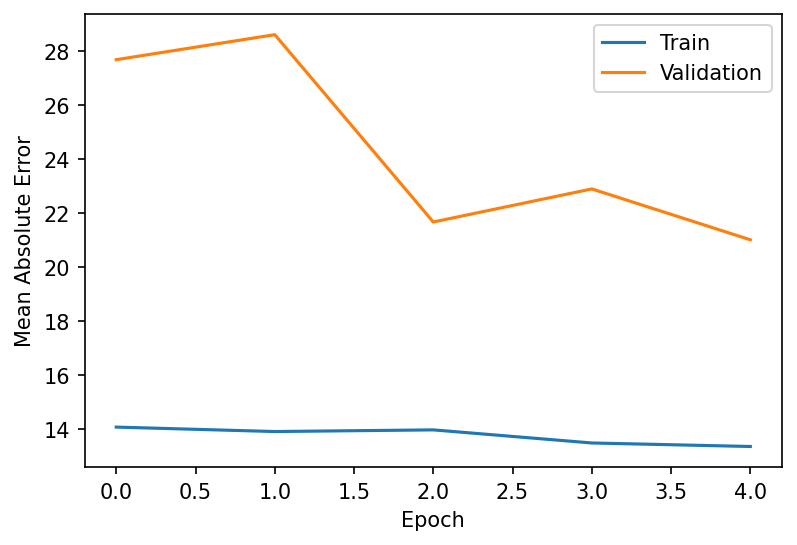

In [42]:
plt.figure(dpi=150 )
plt.plot( train_mae,label = "Train")
plt.plot(val_mae, label = "Validation")
plt.xlabel("Epoch")
plt.ylabel("Mean Absolute Error")
plt.legend()

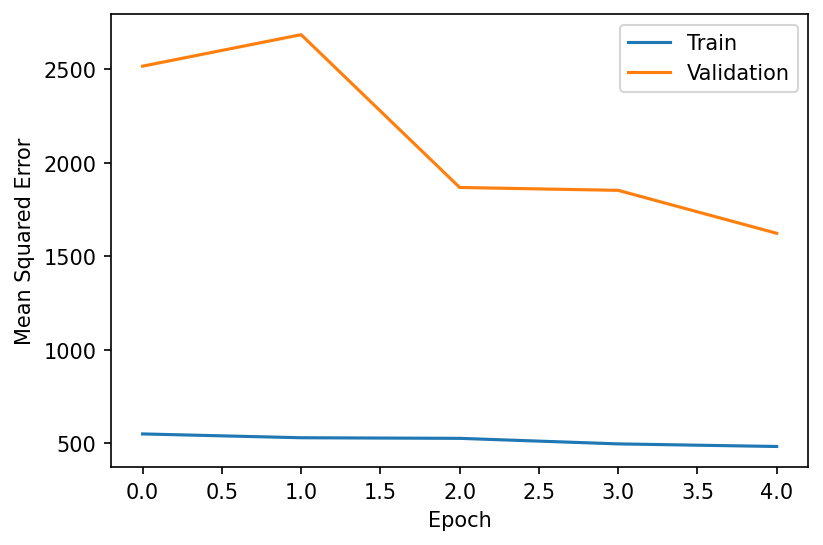

In [43]:
plt.figure(dpi=150 )
plt.plot( train_mse,label = "Train")
plt.plot(val_mse, label = "Validation")
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error")
plt.legend()

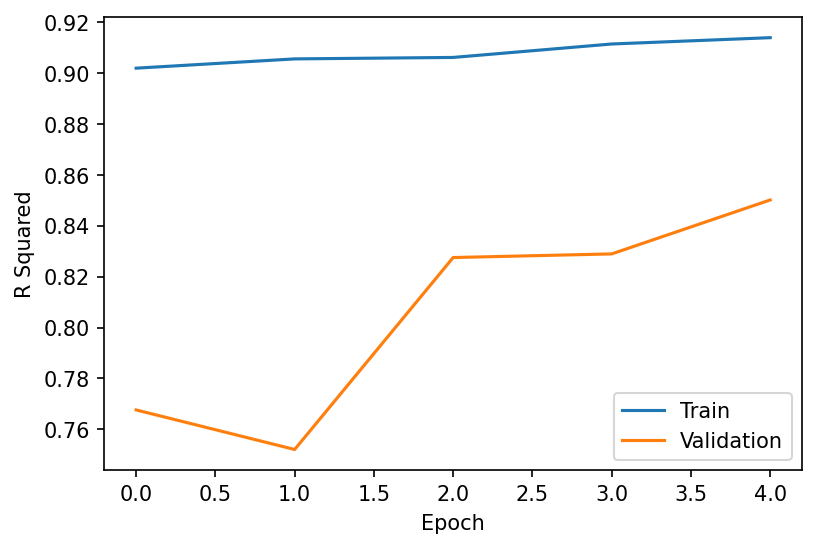

In [44]:
plt.figure(dpi=150 )
plt.plot( train_r2,label = "Train")
plt.plot(val_r2, label = "Validation")
plt.xlabel("Epoch")
plt.ylabel("R Squared")
plt.legend()

# Model Evaluation

In [45]:
model = create_model()
model.load_weights(checkpoint_path)

In [78]:
forecast_train = model.predict(unshuffled_train_set, steps=TRAIN_STEP, verbose=1)
forecast_validation = model.predict(val_set, steps=VALIDATION_STEP, verbose=1)
forecast_test = model.predict(test_set, steps=TEST_STEP, verbose=1)

214/214 [==============================] - 14s 65ms/step


In [53]:
from sklearn.metrics import mean_absolute_error , r2_score , mean_squared_error

In [79]:
val_MAE = mean_absolute_error(labels_val, forecast_validation)
val_R2 = r2_score(labels_val, forecast_validation)
val_RMSE = mean_squared_error(labels_val, forecast_validation)**0.5

In [80]:
train_MAE = mean_absolute_error(labels_Train, forecast_train)
train_R2 = r2_score(labels_Train, forecast_train)
train_RMSE = mean_squared_error(labels_Train, forecast_train)**0.5

In [81]:
test_MAE = mean_absolute_error(labels_Test, forecast_test)
test_R2 = r2_score(labels_Test, forecast_test)
test_RMSE = mean_squared_error(labels_Test, forecast_test)**0.5

In [82]:
print(f"Mean Absolute Error for Validation data: {round(val_MAE,2)}")
print(f"Mean Absolute Error for Train data: {round(train_MAE)}")
print(f"Mean Absolute Error for Test data: {round(test_MAE)}")


print(f"R2 for Validation data: {round(val_R2,2)}")
print(f"R2 for Train data: {round(train_R2,2)}")
print(f"R2 for Test data: {round(test_R2,2)}")


print(f"Root Mean Squared Error for Validation data: {round(val_RMSE,2)}")
print(f"Root Mean Squared Error for Train data: {round(train_RMSE,2)}")
print(f"Root Mean Squared Error for Test data: {round(test_RMSE,2)}")

Mean Absolute Error for Validation data: 21.02
Mean Absolute Error for Train data: 15
Mean Absolute Error for Test data: 17
R2 for Validation data: 0.85
R2 for Train data: 0.9
R2 for Test data: 0.89
Root Mean Squared Error for Validation data: 40.28
Root Mean Squared Error for Train data: 23.44
Root Mean Squared Error for Test data: 28.28
